In [6]:
%pip install -e ..

Obtaining file:///home/rstudio/rl4greencrab
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for rl4greencrab (pyproject.toml) ... done
  Created wheel for rl4greencrab: filename=rl4greencrab-1.0.0-py2.py3-none-any.whl size=972 sha256=0f849313e0aa0136f78ce43f4b591bbce66af57ceb3e9a7cbc8839197bb40600
  Stored in directory: /tmp/pip-ephem-wheel-cache-obnly8hd/wheels/e9/7e/e6/00c4b11a2574abd59d64425d537139e25fadbde37f002c4dba
Successfully built rl4greencrab
  Attempting uninstall: rl4greencrab
    Found existing installation: rl4greencrab 1.0.0
    Uninstalling rl4greencrab-1.0.0:
      Successfully uninstalled rl4greencrab-1.0.0
Note: you may need to restart the kernel to use updated packages.


In [18]:
from rl4greencrab import invasive_IPM_v2 as ipm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

In [24]:
ipm_cfg = {
    'r': 0.5,
    'imm': 2000,
    'problem_scale': 2000,
    'action_reward_scale': 0.5, # cost per unit action in ipm
    'env_stoch': 0.1
}
env = ipm(config=ipm_cfg)

In [20]:
# length of observations quick-n-dirty
nt = len(env.reset()[0])
nt

3

In [21]:
dataframe_collection = {}
for act in np.linspace(-1, 1, 41):
    env.reset()
    ep = []
    for t in range(100):
        obs, rew, term, trunc, info = env.step(np.float32([act]))
        ep.append([t, *obs, rew, sum(env.state)])
        if term or trunc:
            break

    ep_df = pd.DataFrame(ep, columns = ['t', *[f'obs_{i}' for i in range(nt)], 'rew', 'pop'])
    dataframe_collection[act] = ep_df
        
      

In [22]:
# for act, df in dataframe_collection.items():
#     # print(df)
#     df.plot(x='t', y=['pop'], title=f'const_act = {act:.2f}, rew = {np.sum(df.rew)}')
# plt.show()

In [45]:
def gen_ep(env, act):
    env.reset()
    ep = []
    for t in range(100):
        obs, rew, term, trunc, info = env.step(np.float32([act]))
        ep.append([t, *obs, rew, sum(env.state)])
        if term or trunc:
            break

    return pd.DataFrame(ep, columns = ['t', *[f'obs_{i}' for i in range(nt)], 'rew', 'pop'])

import ray
@ray.remote
def gen_ep_rew(env, act):
    env.reset()
    ep_rew=0
    for t in range(100):
        obs, rew, term, trunc, info = env.step(np.float32([act]))
        ep_rew += rew
        if term or trunc:
            break
    return ep_rew

def avg_rew(env, act):
    return np.mean(
        ray.get(
            [gen_ep_rew.remote(env, act) for _ in range(100)]
        )
    )

from tqdm import tqdm
def tune_const_action(env):
    actions = []
    mean_rews = []
    for act in tqdm(np.linspace(-1,0,51)):
        actions.append(act)
        mean_rews.append(avg_rew(env, act))
    return pd.DataFrame({'action': actions, 'reward': mean_rews})

In [46]:
env = ipm(config=ipm_cfg)
const_tuning = tune_const_action(env)

100%|██████████| 51/51 [00:14<00:00,  3.43it/s]


In [48]:
const_tuning.head(10)

,action,reward
0,-1.00,-20.174471
1,-0.98,-10.846384
2,-0.96,-5.033233
3,-0.94,-3.303023
4,-0.92,-2.987219
5,-0.90,-3.134735
6,-0.88,-3.455575
7,-0.86,-3.854592
8,-0.84,-4.290495
9,-0.82,-4.747434


<Axes: xlabel='t'>

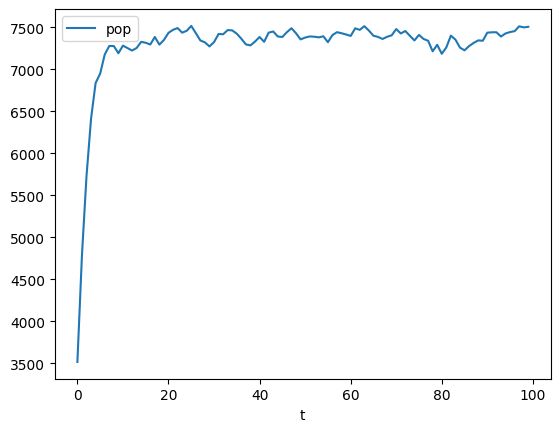

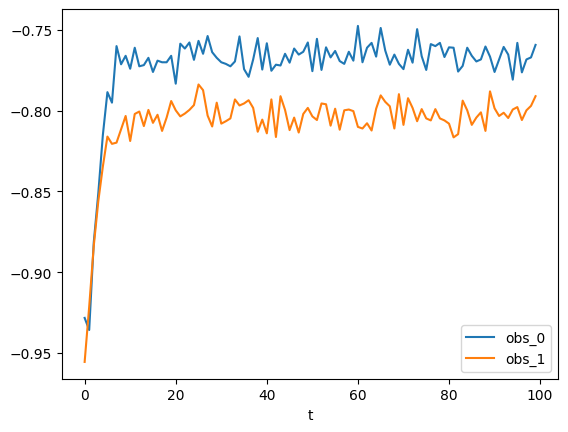

In [60]:
ep = gen_ep(act=-.92, env=env) # <- using the optimal constant action from the cell above
ep.plot(x='t', y=['pop'])
ep.plot(x='t', y=['obs_0', 'obs_1'])